Notebook based on _Hands-On Graph Neural Networks Using Python_, by Maxime Labonne.

# Ch 3. Creating Node Representations with DeepWalk

This chapter presents a simple modern approach for generating node representations: DeepWalk. It is inspired by the Word2Vec approach from natural language processing (NLP), which generates word embeddings from sentence data.

Ideally we would like to generate node embeddings from graph data, but the problem is that the graphs don't have obvious counterparts to the sentences that appear in sentence data. That's where DeepWalk comes in. The idea is generate a bunch of random walks for the various graph nodes. The random walks provide a context for learning node embeddings in the same way that sentences provide a context for learning word embeddings. We then run Word2Vec on the random walk data.

First we cover Word2Vec, since we need that for both word and node embeddings. After that, we show how to use DeepWalk to generate random walks from the graph, and we run Word2Vec on the random walks to generate the embeddings. Finally, we train a random forest classifier on the graph embeddings.

As noted above, DeepWalk is a simple approach, but it serves as a good baseline. In the following chapter we'll look at a more sophisticated approach called Node2Vec.

In [1]:
import random

from gensim.models.word2vec import Word2Vec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

In [2]:
random.seed(0)

## 3.1 Generate word embeddings (Word2Vec)

### 3.1.1 Text data

Source: https://www.zerohedge.com/markets/china-canada-retaliate-against-trumps-tariff-war-global-stocks-slide

In [3]:
text = """First there were the Trump Tariffs... then the Retaliation. Then as Europe closed, chatter about a possible Ukraine minerals deal started to gain momentum lifting stocks to the highs.
With a few minutes left in the day, a large MoC sell imbalance sent stocks back down hard...
But, just as we predicted here... Commerce Secretary Howard Lutnick spoke on Fox Business, offering the dovish olive branch: 
"Both the Mexicans and the Canadians were on the phone with me all day today trying to show that they'll do better, and the president's listening, because you know he's very, very fair and very reasonable," Lutnick said in an interview with Fox Business. 
"So I think he's going to work something out with them — it's not going to be a pause, none of that pause stuff, but I think he's going to figure out: you do more and I'll meet you in the middle some way and we're going to probably announcing that tomorrow."
As Bloomberg reports, Lutnick did not explicitly say what President Donald Trump was considering after imposing an across-the-board tariff on all goods from Canada and Mexico that went into effect overnight. 
Lutnick said that the tariffs would likely land "somewhere in the middle" with Trump "moving with the Canadians and Mexicans, but not all the way."
Lutnick discounted the notion that the tariffs would be fully rolled back, pointing instead to the US-Mexico-Canada trade pact negotiated during Trump's first term.
"If you live under those rules, then the president is considering giving you relief," Lutnick said.
"If you haven't lived under those rules, well, then you have to pay the tariff."
and lifted US equity futures higher after the close... And the Peso and Loonie are also bid with both hands and feet... So, the Trump 1.0 tariff playbook analog continues. Asian markets closed lower, European stocks are in the red, and US equity futures are trending lower this morning as worsening global trade war concerns weigh on risk sentiment.
On Monday, President Trump reiterated that he would impose tariffs on imports from Canada and Mexico starting Tuesday, stating that there was "no room left" for negotiation. He also noted that an additional 10% levy would be applied to imports from China.
Fast-forward to Tuesday morning. Trump's 25% tariffs on goods from Mexico and Canada took effect, prompting Canada to retaliate with 25% tariffs on $100 billion worth of US imports. Mexico is expected to respond later.
Trump also introduced an additional 10% tariff on Chinese imports early Tuesday, bringing the total tax to 20% following a similar increase last month. China swiftly retaliated with tariffs on US food and agricultural products and an export ban on some defense firms. 
According to an announcement by the Chinese Ministry of Finance, Beijing imposed new duties of 10% to 15% on US food and agricultural products. 
Here's an excerpt from the announcement: 
15% tariff will be imposed on chicken, wheat, corn, and cotton.
10% tariff will be imposed on sorghum, soybeans, pork, beef, aquatic products, fruits, vegetables, and dairy products
For the imported goods listed in the appendix originating from the United States, corresponding tariffs will be levied on the basis of the current applicable tariff rates. The current bonded and tax reduction and exemption policies remain unchanged, and the additional tariffs will not be reduced or exempted
Goods that have been shipped from the place of departure prior to March 10, 2025, and imported from March 10, 2025 to April 12, 2025, shall not be subject to the additional tariffs prescribed in this announcement
Commenting on China's retaliatory tariffs, Lynn Song, chief economist for Greater China at ING Bank, told clients: "The measures are still relatively measured for now. I think this retaliation shows China remains patient and has refrained from 'flipping the table' so to speak despite the recent escalation."
"China's hit-back isn't exactly aggressive — a 15% tariff on US agricultural goods, but nothing broad-based on tech or autos, suggests to me they're leaving room for negotiation," said Billy Leung, an investment strategist at Global X ETF, adding, "That's probably why Chinese stocks are rebounding instead of selling off harder."
Dilin Wu, a research strategist at Pepperstone Group Ltd., said, "The immediate impact of these new tariffs on China remains manageable — the measures are currently concentrated in specific areas."
"Should Beijing roll out additional pro-growth measures — such as large-scale fiscal stimulus or targeted support for high-tech industries and domestic consumption — it could further bolster market confidence," Wu said. 
Sea of red for global equity futures across most regions. China's Ministry of Finance warned:  "The US's unilateral tariff increase damages the multilateral trading system, increases the burden on US companies and consumers, and undermines the foundation of economic and trade cooperation between China and the US." 
Should Trump respond with retaliatory tariffs, the risk of sentiment continuation could continue. In the US, the growth outlook has dimmed as the troubling narrative of "growth scare and tariffs" takes center stage. 
""".replace('.', '').lower().split()

In [4]:
text[0:5]

['first', 'there', 'were', 'the', 'trump']

### 3.1.2 Extract skip-grams from the text

Skip-grams are words that appear in the same context. There's a center word, and then the context contains words within a certain window (either forward or backward) of that center word. The pairs (center_word, surrounding_word) become the training pairs.

NOTE: We don't directly use the following skip-grams in the Word2Vec training below, as Word2Vec handles skip-grams internally. This section is for illustration.

In [5]:
print(f'n_vocab={len(set(text))}')

n_vocab=456


In [6]:
skipgrams = []

CONTEXT_SIZE = 2
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    array = [text[j] for j in np.arange(i - CONTEXT_SIZE, i + CONTEXT_SIZE + 1) if j != i]
    skipgrams.append((text[i], array))

for sg in skipgrams[0:10]:
    print(sg)

('were', ['first', 'there', 'the', 'trump'])
('the', ['there', 'were', 'trump', 'tariffs'])
('trump', ['were', 'the', 'tariffs', 'then'])
('tariffs', ['the', 'trump', 'then', 'the'])
('then', ['trump', 'tariffs', 'the', 'retaliation'])
('the', ['tariffs', 'then', 'retaliation', 'then'])
('retaliation', ['then', 'the', 'then', 'as'])
('then', ['the', 'retaliation', 'as', 'europe'])
('as', ['retaliation', 'then', 'europe', 'closed,'])
('europe', ['then', 'as', 'closed,', 'chatter'])


### 3.1.3 Generate word embeddings using Word2Vec

Word2Vec comes from Natural Language Processing (NLP), and it generates word embeddings from input text. The basic approach is to look at all the places where some given word appears in a text
To do this, we have to maximimize the sum of every probability of seeing a context word $w_{i+j}$ given a target word $w_i$ in an entire text:

$$
\frac{1}{N} \sum_{i=1}^{N} \sum_{-c \leq j \leq c, j \neq 0} \log P(w_{i+j}|w_i)
$$

where $N$ is the number of words and $c$ is the size of the context vector.

Word2Vec params:
- `sentences`: Sentences to process.
- `sg`: 1 for skip-gram, otherwise continuous bag of words (CBOW, default).
- `vector_size=10`: This sets the dimensionality of the word vectors (embeddings) to 10.
- `min_count=0`: This specifies that all words, regardless of their frequency, will be included in the training. Typically, a higher value is used to ignore infrequent words.
- `window=2`: This sets the context window size to 2, meaning the model will consider up to 2 words on either side of the target word.
- `workers=2`: This sets the number of worker threads to use for training the model. More workers can speed up the training process.
- `seed=0`: This sets the random seed for reproducibility, ensuring that the results are consistent across different runs.
- `hs=0` (default): Use hierarchical softmax?

In [7]:
# See https://github.com/piskvorky/gensim/blob/develop/gensim/models/word2vec.py
model = Word2Vec(
    sentences=[text],
    sg=1,  # 0=CBOW, 1=skip-gram
    vector_size=10,
    min_count=0,
    window=CONTEXT_SIZE,
    workers=2,
    seed=0,
)
print(f"Shape of W_embed: {model.wv.vectors.shape}")
model.train([text], total_examples=model.corpus_count, epochs=10)

Shape of W_embed: (456, 10)


(6252, 8340)

In [8]:
for i in range(5):
    print(model.wv[i])

[ 0.14280146  0.09729277  0.09041546 -0.17795573  0.1387754   0.04538346
 -0.19842224 -0.20436211 -0.07401148  0.178989  ]
[ 0.09593026  0.1586517   0.09231183 -0.10278397  0.2633366   0.1779969
 -0.07683916 -0.0872191   0.00582872  0.19203804]
[ 0.00665414  0.11551753  0.0971594  -0.19095473  0.09960869  0.16353752
 -0.06878774 -0.16476248  0.0478036   0.1232558 ]
[ 0.11850564 -0.01173416 -0.01203751 -0.02081964  0.03126835  0.11890978
 -0.16596946 -0.11970951 -0.01098071  0.06007912]
[ 0.02604508 -0.05527187 -0.05314316 -0.15556765  0.00435676  0.11965473
 -0.06281351 -0.03673835 -0.05510545  0.08838237]


## 3.2 Generate node embeddings (DeepWalk + Word2Vec)

### 3.2.1 Introduction to random walks on graphs

In [9]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

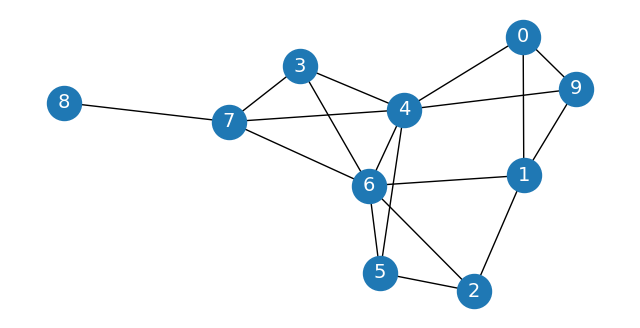

In [10]:
plt.figure(figsize=(8, 4))
plt.axis('off')
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=0),
    node_size=600,
    font_size=14,
    font_color='white'
)

In [11]:
def random_walk(graph, start, length):
    walk = [str(start)]  # starting node

    for i in range(length):
        neighbors = [node for node in graph.neighbors(start)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node

    return walk

In [12]:
print(random_walk(G, 0, 10))

['0', '4', '9', '1', '9', '0', '1', '9', '1', '0', '9']


### 3.2.2 DeepWalk on Zachary's Karate Club graph

In [13]:
zkc_graph = nx.karate_club_graph()

In [14]:
labels = []
for node in zkc_graph.nodes:
    # print(zkc_graph.nodes[node])
    label = zkc_graph.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

In [15]:
def plot_graph(graph, labels):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    nx.draw_networkx(
        graph,
        pos=nx.spring_layout(graph, seed=0),
        node_color=labels,
        node_size=800,
        cmap='coolwarm',
        font_size=14,
        font_color='white'
    )

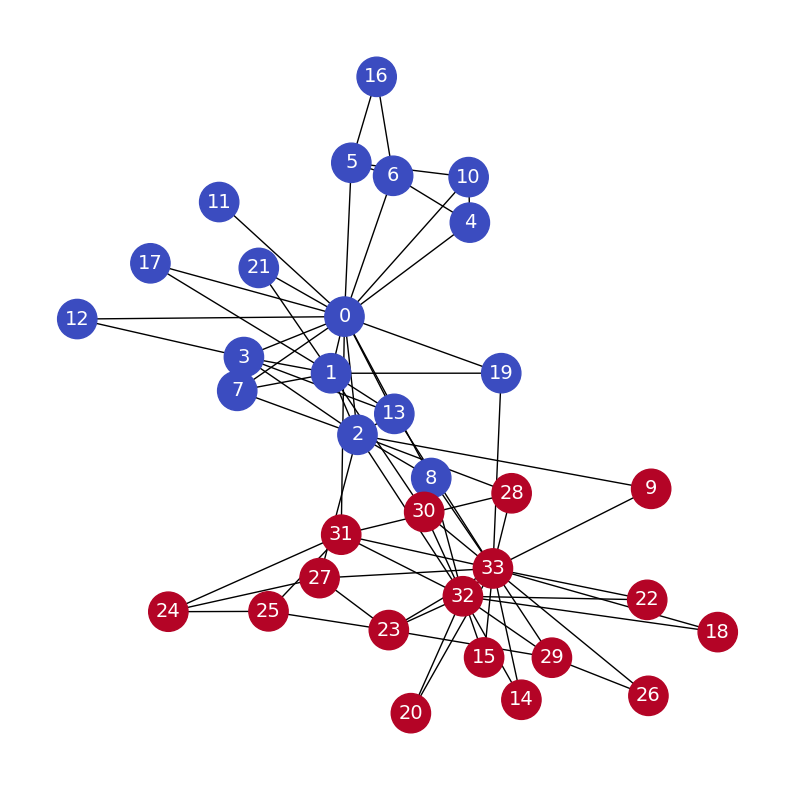

In [16]:
plot_graph(zkc_graph, labels)

In [17]:
# Generate the random walks. Note that we generate lots of random walks for each node.
walks = []
for node in zkc_graph.nodes:
    for _ in range(80):
        walks.append(random_walk(zkc_graph, node, 10))

In [18]:
print(walks[0])

['0', '11', '0', '2', '0', '1', '30', '1', '19', '33', '28']


### 3.2.3 Train Word2Vec model on ZKC random walks

In [19]:
model = Word2Vec(
    walks,
    hs=1,  # hierarchical softmax
    sg=1,  # 0=CBOW, 1=skip-gram
    vector_size=100,
    window=10,
    workers=2,
    seed=0
)

In [20]:
model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

(187160, 897600)

In [21]:
# Node 4 embedding
print(model.wv['4'])

[ 0.06210205  0.29526427  0.2125098  -0.03770777 -0.02238093  0.31664285
  0.03862415 -0.38721067  0.07094274  0.04601819 -0.09112624 -0.07710844
  0.10994274 -0.0377762  -0.179532   -0.18568635 -0.21631409  0.11405982
  0.2942628  -0.07922681  0.24663496  0.38470888 -0.01965159  0.2638427
  0.35981524  0.22991511  0.3705543  -0.08394504  0.09626638 -0.28604928
  0.21399923  0.05397114  0.39248714 -0.24973156 -0.22559689  0.22798665
 -0.02748404  0.12265339  0.1671864  -0.50612754 -0.17839277 -0.04590964
 -0.23034829 -0.24936436 -0.131686   -0.02404263 -0.19594033 -0.02758136
  0.05757815 -0.25943232  0.06505328 -0.22878827  0.13170671  0.27548775
  0.41169763  0.16693856 -0.10504013 -0.01189118 -0.33998582  0.1957825
  0.02485383  0.16204654 -0.13033506  0.14573486  0.10595322  0.01408317
  0.1477994  -0.08053984  0.15800518  0.04699038  0.09209592 -0.10981622
  0.17961203 -0.16232838  0.08238328 -0.18278795  0.01820624 -0.23882926
 -0.27775404  0.29852563  0.24736123  0.4437923   0.0

In [22]:
print('Nodes that are the most similar to node 0:')
for similarity in model.wv.most_similar(positive=[0]):
    print(f'    {similarity}')

Nodes that are the most similar to node 0:
    ('22', 0.7671635746955872)
    ('14', 0.7471351623535156)
    ('32', 0.7414161562919617)
    ('18', 0.7387385368347168)
    ('15', 0.719031572341919)
    ('29', 0.7111870646476746)
    ('20', 0.7084903717041016)
    ('26', 0.6634713411331177)
    ('23', 0.5897699594497681)
    ('31', 0.5158575177192688)


In [23]:
print(f"Similarity between nodes 0 and 4: {model.wv.similarity('0', '4')}")

Similarity between nodes 0 and 4: 0.6529626250267029


### 3.2.4 Visualize embeddings using T-SNE

In [24]:
# Node embeddings
# Note that we cast the node indices to string since these are "words"
embeddings = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])

# Labels
labels = np.array(labels)

In [25]:
tsne = TSNE(
    n_components=2,
    learning_rate='auto',
    init='pca',
    random_state=0).fit_transform(embeddings)

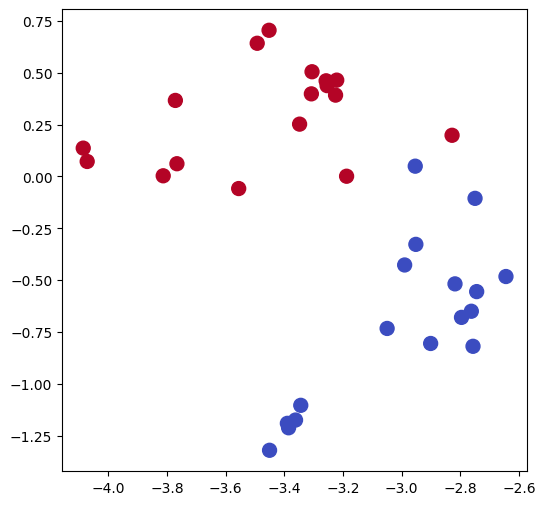

In [26]:
plt.figure(figsize=(6, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap='coolwarm')
plt.show()

## 3.3 Application: Train random forest classifier on ZKC embeddings

In [27]:
def get_embeddings_and_labels(model, labels, mask):
    mask_str = [str(x) for x in mask]
    return model.wv[mask_str], labels[mask]

In [28]:
train_mask = list(range(0, 29, 2))
train_embs, train_labels = get_embeddings_and_labels(model, labels, train_mask)

test_mask = list(range(1, 30, 2)) + [30, 31, 32, 33]
test_embs, test_labels = get_embeddings_and_labels(model, labels, test_mask)

In [29]:
clf = RandomForestClassifier(random_state=0)
clf.fit(train_embs, train_labels)

RandomForestClassifier(random_state=0)

In [30]:
y_pred = clf.predict(test_embs)
accuracy_score(y_pred, test_labels)

1.0

In [31]:
y_pred

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [32]:
test_labels

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

## 3.4 Further reading

- [DeepWalk: Online Learning of Social Representations](https://arxiv.org/abs/1403.6652)